# Proposal :  FOREX Strategy analysis

# Problem Statement

1. IDEAL

Create a model that identifies technical indicators and then predicts the subsequent price movement in the market. This will initially focus on Marubuzo.


2. REALITY

The FOREX market and all stock market prices are very hard to predict. The price movements are often described as completely random. The time series is effected by a lot of external factors other than date. Therefore the probability of getting a good prediction is low. 

So I will look at adding key exogenous or external features to help with the prediction.

I will look to include:
   + Inflation rates
   + Interest rates
   + Volatility
   + Moving Averages on 3 time lags
   

Technical traders believe that these factors are already accounted for in the prices or rates. Therefore the chart patterns can be all you need to look at. It will be interesting to see if they do have an impact on price prediction.


3. CONSEQUENCES

Currently traders have trouble predicting their entry and exit points. They are often right but either miss a trade, get stopped out too soon or in trying to find maximum profit miss time their exit. Without this model to give them guidelines to work with

4. PROPOSAL

After comparing 3 algorithms ARIMAX, SARIMAX and Prophet I will create a final model to predict the highest stock price in the next 3 time frames. 

I will use RMSE as my accuracy score. My benchmark will be predicting the current price. I choose this due to high correlation in the prior prices. Given the nature of the randomness of the stock market this might be harder to beat than it sounds.


A key area would be to infer what the strategy implications are and explain the key factors to success or failure of the model.


Bonus:
+ Learn how to implemnet a bot on a trading account
+ Create a python based web app to track results

# Data Source

I have found EUR/USD data from a recommended website. It has minute data starting from 2000.

[Hist Data - Free Historical Data](https://www.histdata.com/)

# Project Overview


### EDA 

#### Create a function/Program to:
+ Loop through the data to produce the candle sticks in the correct timeframe

+ Loop through and identify where the candle sticks meet the pattern

+ Create TARGET feature by finding the highest price over next 3 time frames

+ Create other features:


    + Moving averages over different time frames
    + Create volatility index


### Pre processing

#### Steps
+ Stationarity - Dickey-Fuller test
+ Create differences where necessary
+ Check for seasonality


#### Modelling
+ Investigate how to do appropriate cross train split for time series
    + [scikit learn help](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
    + [back testing help](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)
+ Cross train split
+ Alogithm comparison with grid serach
    + Compare accuracy
    + Compare overfittin on valitdation set

+ Tune Final model with manual gridsearch

### Conclusions
+ How did models perform
+ Key observations and learnings

### Bonus
+ Create Bot
+ Creat web app to track


---

# load Data and EDA

---

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [156]:
header_list = ['date','open','high','low','close','misc']

In [157]:
for i in range(2000,2020):
    if i == 2000:
        eur_usd = pd.read_csv('./Data/csv/EURUSD_' + str(i) + '.csv', 
                              parse_dates=True, names=header_list, index_col='date')
    else:
        df = pd.read_csv('./Data/csv/EURUSD_' + str(i) + '.csv', 
                         parse_dates=True, names=header_list, index_col='date')
        eur_usd = pd.concat([eur_usd, df])

In [158]:
# Check Shape
eur_usd.shape

(6539013, 5)

In [177]:
# Check data types
eur_usd.dtypes

open     float64
high     float64
low      float64
close    float64
dtype: object

In [176]:
eur_usd.head(15)

,open,high,low,close
date,,,,
2000-05-30 17:27:00,0.9302,0.9302,0.9302,0.9302
2000-05-31 00:50:00,0.9315,0.9315,0.9315,0.9315
2000-05-31 00:51:00,0.9315,0.9315,0.9315,0.9315
2000-05-31 00:55:00,0.9317,0.9317,0.9317,0.9317
2000-05-31 01:01:00,0.9318,0.9318,0.9318,0.9318
2000-05-31 01:07:00,0.9317,0.9317,0.9317,0.9317
2000-05-31 01:09:00,0.9318,0.9319,0.9318,0.9319
2000-05-31 01:11:00,0.9321,0.9322,0.9321,0.9321
2000-05-31 01:18:00,0.9322,0.9322,0.9322,0.9322


In [160]:
# Look at the statistics
eur_usd.describe()

,open,high,low,close,misc
count,6.539013e+06,6.539013e+06,6.539013e+06,6.539013e+06,6539013.0
mean,1.228013e+00,1.228118e+00,1.227910e+00,1.228014e+00,0.0
std,7.831060e-01,7.831092e-01,7.831029e-01,7.831061e-01,0.0
min,-1.000000e-04,-1.000000e-04,-1.000000e-04,-1.000000e-04,0.0
25%,1.123140e+00,1.123230e+00,1.123060e+00,1.123140e+00,0.0
50%,1.236500e+00,1.236600e+00,1.236400e+00,1.236500e+00,0.0
75%,1.336480e+00,1.336570e+00,1.336390e+00,1.336480e+00,0.0
max,1.965000e+03,1.965000e+03,1.965000e+03,1.965000e+03,0.0


### Investigate outliers

In [161]:
eur_usd.loc[(eur_usd['open'] < 0) | (eur_usd['high'] < 0) |(eur_usd['low'] < 0) | (eur_usd['close'] < 0)]

,open,high,low,close,misc
date,,,,,
2001-09-11 20:12:00,-0.0001,-0.0001,-0.0001,-0.0001,0.0


In [162]:
eur_usd.loc[(eur_usd['open'] > 100) | (eur_usd['high'] > 100) |(eur_usd['low'] > 100) | (eur_usd['close']  > 100)]

,open,high,low,close,misc
date,,,,,
2001-06-07 23:32:00,1965.0001,1965.0001,1965.0001,1965.0001,0.0


#### Investigate outliers and cross cheeck from different online sources

+ First one looks like an error
+ Second one looks like its probably wrong as well even if decimal place is corrected.


In [180]:
# Drop 2 rows for now until investigated further
eur_usd.drop(eur_usd.loc[(eur_usd['open'] < 0) | (eur_usd['high'] < 0) 
                         |(eur_usd['low'] < 0) | (eur_usd['close'] < 0)].index, inplace=True)

In [181]:
eur_usd.drop(eur_usd.loc[(eur_usd['open'] > 100) | (eur_usd['high'] > 100) 
                         |(eur_usd['low'] > 100) | (eur_usd['close']  > 100)].index, inplace=True) 


In [165]:
# drop 'misc' columns as there is nothing there
eur_usd.drop(columns='misc', inplace=True)

In [166]:
eur_usd.head()

,open,high,low,close
date,,,,
2000-05-30 17:27:00,0.9302,0.9302,0.9302,0.9302
2000-05-31 00:50:00,0.9315,0.9315,0.9315,0.9315
2000-05-31 00:51:00,0.9315,0.9315,0.9315,0.9315
2000-05-31 00:55:00,0.9317,0.9317,0.9317,0.9317
2000-05-31 01:01:00,0.9318,0.9318,0.9318,0.9318


In [167]:
# See shape
eur_usd.shape

(6539011, 4)

In [168]:
# Check for missing data
eur_usd.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

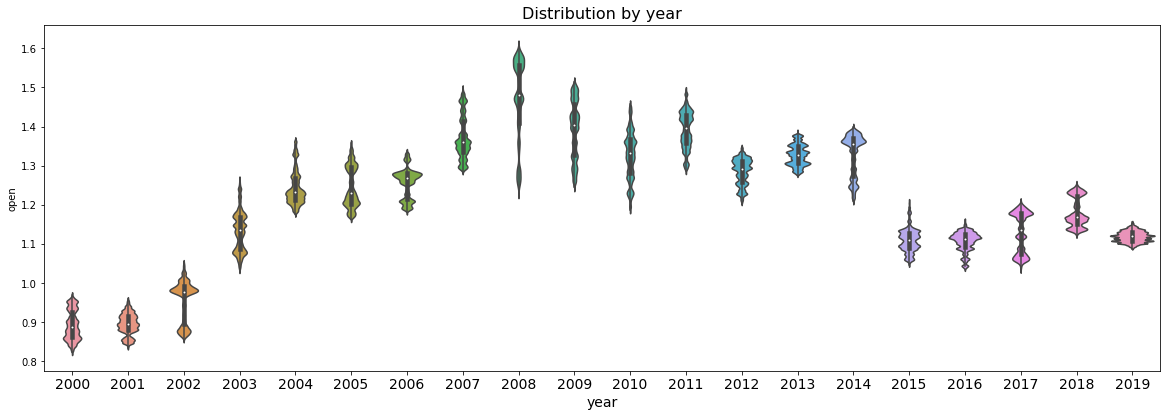

In [173]:
# Plot violin charts to see the distibutions and spread of data
plt.subplots(figsize=(20,14))

# By year
ax1 = plt.subplot(2,1,1)
sns.violinplot(x=eur_usd.index.year, y='open', data=eur_usd).set_xlabel('year', size=14)
plt.title('Distribution by year', size=16)
plt.xticks(size=14)
